In [ ]:
import polars as pl
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import threshold_helpers as th
from skimage.filters import threshold_otsu, threshold_triangle
import plotly.graph_objects as go
import plotly.io as pio
import squidpy as sq

In [3]:
np.random.seed(0)

In [4]:
df = pl.read_csv("CRC01_single_cell_table.csv")
df = df.to_pandas()

# subset for faster computation when debugging
#df = df.iloc[:5000, ]
#df

In [5]:
cols = df.columns
marker_cols = cols[1: -9]
coord_cols = cols[-9: -7]
# remove certain elements
marker_cols = [mc for mc in marker_cols if mc not in ["Hoechst", "Argo550", "AF1"]]
marker_cols

['CD31',
 'CD45',
 'CD68',
 'CD4',
 'FOXP3',
 'CD8a',
 'CD45RO',
 'CD20',
 'PD-L1',
 'CD3e',
 'CD163',
 'E-cadherin',
 'PD-1',
 'Ki67',
 'Pan-CK',
 'SMA']

In [6]:
adata = sc.read("temp_adata.h5ad")
print(adata)

/opt/miniconda3/envs/Summer2025/lib/python3.13/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 1620375 × 16
    obs: 'CellID', 'Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity', 'Solidity', 'Extent', 'Orientation', 'leiden_clusters'
    var: 'mean', 'std'
    uns: 'leiden_clusters', 'leiden_clusters_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'log1p', 'raw', 'scaled'
    obsp: 'connectivities', 'distances'


In [7]:
# Dominant markers
top_genes =  pd.DataFrame(adata.uns["rank_genes_groups"]["names"])
print(top_genes.iloc[0:3, ])

num_clusters = len(top_genes.columns)
print(num_clusters)

        0      1       2      3     4           5      6      7     8     9  \
0  Pan-CK   CD31  CD45RO   CD68  CD8a        Ki67    SMA    SMA  CD20  CD8a   
1   CD163    SMA    CD45  CD163  CD3e        PD-1  CD163  CD163  CD45  CD3e   
2     SMA  CD163   FOXP3    CD4  PD-1  E-cadherin   CD45   CD31  CD31  CD45   

   ...          16          17          18          19    20          21  \
0  ...  E-cadherin  E-cadherin      Pan-CK        Ki67  Ki67      Pan-CK   
1  ...        PD-1        PD-1  E-cadherin      Pan-CK  PD-1  E-cadherin   
2  ...        Ki67      Pan-CK        Ki67  E-cadherin  CD20        PD-1   

      22    23     24     25  
0   PD-1   SMA  PD-L1    CD4  
1   Ki67  CD31  FOXP3   CD68  
2  FOXP3   CD4   CD20  PD-L1  

[3 rows x 26 columns]
26


In [8]:
print(adata.obs)

          CellID  Area  MajorAxisLength  MinorAxisLength  Eccentricity  \
0              1   588        41.882124        18.370334      0.898673   
1              2   740        43.965194        22.187973      0.863312   
2              3   193        18.694776        13.708441      0.679931   
3              4   408        23.768887        21.976172      0.380995   
4              5  1494        74.087383        26.469302      0.934001   
...          ...   ...              ...              ...           ...   
1620370  1620371   497        28.448086        22.773829      0.599279   
1620371  1620372   221        21.540405        13.837058      0.766389   
1620372  1620373   394        26.139311        19.355939      0.672066   
1620373  1620374   339        22.896479        18.906752      0.564037   
1620374  1620375   340        25.091927        18.332011      0.682812   

         Solidity    Extent  Orientation leiden_clusters  
0        0.981636  0.864706     1.533761            

In [9]:
sub_markers = ["E-cadherin", "Pan-CK", "CD45", "CD3e", "CD8a"]

for marker in marker_cols:
    temp = adata[:, marker].layers["log1p"].flatten()
    thr = threshold_otsu(temp)
    print(thr)
    labs = (temp >= thr).astype(int)

    adata.obs[f"{marker}_strat"] = labs



5.766810811876025
6.2158191781286565
5.989846486823469
5.770297828704237
5.72068178402513
5.922373279233398
6.123432728252547
5.958466737802109
5.955757773176455
6.096258095393861
5.7732183738683815
6.023722861953278
5.6981179271426825
5.943866721498228
6.162268998482873
5.6904296151634925


In [10]:
gene_df = sc.get.obs_df(adata, keys=["leiden_clusters", *sub_markers], layer="log1p")
# convert to pandas
gene_df = pl.DataFrame(gene_df)

# convert leiden_clusters to numeric
gene_df = gene_df.with_columns(pl.col("leiden_clusters").cast(pl.Int64))


In [11]:
met = pl.DataFrame(adata.obs)

met = met.with_columns(pl.col("leiden_clusters").cast(pl.Int64))

# sanity check to make sure leiden_clusters of both met and gene_df are in the same order
assert all(met["leiden_clusters"] == gene_df["leiden_clusters"])

# remove leiden clusters column from gene_df
temp = gene_df.drop("leiden_clusters")

data = pl.concat([met, temp], how="horizontal")
print(data.columns)

data = data.drop(data.columns[1:8])


['CellID', 'Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity', 'Solidity', 'Extent', 'Orientation', 'leiden_clusters', 'CD31_strat', 'CD45_strat', 'CD68_strat', 'CD4_strat', 'FOXP3_strat', 'CD8a_strat', 'CD45RO_strat', 'CD20_strat', 'PD-L1_strat', 'CD3e_strat', 'CD163_strat', 'E-cadherin_strat', 'PD-1_strat', 'Ki67_strat', 'Pan-CK_strat', 'SMA_strat', 'E-cadherin', 'Pan-CK', 'CD45', 'CD3e', 'CD8a']


In [12]:
data = data.with_columns(
    pl.lit(None).alias("Cluster Annotation")
)
data = data.to_pandas()

In [13]:
# how to convince someone that the tumor and cd8 T cell annotations are correct?

# "cluster" annotations would be according to top markers, and all cells in that cluster would be manually assigned that cell type

# annotate cells according to cell dictionary (pos & neg marker list)

cell_ref = {
    "Tumor Cell": {"pos": ["E-cadherin"], "neg": ["CD45", "CD3e", "CD8a", "CD20", "CD68", "FOXP3", "SMA", "CD31", "CD4", "CD45RO", "CD163"]},
    "CD8 T Cell": {"pos": ["CD45", "CD3e", "CD8a"], "neg": ["CD68", "CD4", "FOXP3", "CD20", "CD163", "E-cadherin", "Pan-CK", "SMA"]}
}

In [14]:
for cell_type, marker_dict in cell_ref.items():
    print(f"Processing cell type: {cell_type}")
    pos_markers = marker_dict["pos"]
    pos_markers = [marker + "_strat" for marker in pos_markers]
    neg_markers = marker_dict["neg"]
    neg_markers = [marker + "_strat" for marker in neg_markers]
    pos_mask = np.all([data[marker] > 0 for marker in pos_markers], axis=0)
    neg_mask = np.all([data[marker] <= 0 for marker in neg_markers], axis=0)

    cell_type_mask = pos_mask & neg_mask
    data.loc[cell_type_mask, "Cell Type"] = cell_type

# fill in any blanks in "Cell Type" column with "Not Assigned"
data["Cell Type"].fillna("Not Assigned", inplace=True)

Processing cell type: Tumor Cell
Processing cell type: CD8 T Cell


/var/folders/br/wg7_xdjd56j7rb8h39m_2f240000gn/T/ipykernel_83100/127792357.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["Cell Type"].fillna("Not Assigned", inplace=True)


In [15]:
data

,CellID,leiden_clusters,CD31_strat,CD45_strat,CD68_strat,CD4_strat,FOXP3_strat,CD8a_strat,CD45RO_strat,CD20_strat,...,Ki67_strat,Pan-CK_strat,SMA_strat,E-cadherin,Pan-CK,CD45,CD3e,CD8a,Cluster Annotation,Cell Type
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,5.220457,5.368944,5.383941,5.211964,5.250509,None,Not Assigned
1,2,1,1,0,0,0,0,0,0,0,...,0,0,0,5.361907,5.349588,6.096482,5.584760,5.605817,None,Not Assigned
2,3,11,0,0,0,0,0,0,0,0,...,0,0,0,5.204007,5.357344,5.288293,5.175740,5.263066,None,Not Assigned
3,4,23,0,0,0,0,0,0,0,0,...,0,0,1,5.254389,4.924550,5.385608,5.433433,5.365644,None,Not Assigned
4,5,23,0,0,0,0,0,0,0,0,...,0,0,1,5.272533,5.072614,5.423510,5.491416,5.383435,None,Not Assigned
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1620370,1620371,15,0,0,0,0,0,0,0,0,...,0,0,0,3.052634,5.971267,5.621093,3.990548,5.372461,None,Not Assigned
1620371,1620372,15,0,0,0,0,0,0,0,0,...,0,0,0,3.299016,5.959033,5.396933,3.817165,5.393525,None,Not Assigned
1620372,1620373,15,0,0,0,0,0,0,0,0,...,0,0,0,3.055939,5.966205,5.377251,3.910652,5.392381,None,Not Assigned
1620373,1620374,15,0,0,0,0,0,0,0,0,...,0,0,0,3.352230,5.978542,5.386307,3.181122,5.352934,None,Not Assigned


In [16]:
for clust in top_genes.columns:
    top3 = top_genes[clust].iloc[:3].tolist()
    print(f"Cluster {clust}: {', '.join(top3)}")


Cluster 0: Pan-CK, CD163, SMA
Cluster 1: CD31, SMA, CD163
Cluster 2: CD45RO, CD45, FOXP3
Cluster 3: CD68, CD163, CD4
Cluster 4: CD8a, CD3e, PD-1
Cluster 5: Ki67, PD-1, E-cadherin
Cluster 6: SMA, CD163, CD45
Cluster 7: SMA, CD163, CD31
Cluster 8: CD20, CD45, CD31
Cluster 9: CD8a, CD3e, CD45
Cluster 10: CD3e, CD4, CD45
Cluster 11: PD-L1, CD20, SMA
Cluster 12: Pan-CK, CD68, E-cadherin
Cluster 13: PD-L1, CD20, CD8a
Cluster 14: Ki67, E-cadherin, Pan-CK
Cluster 15: PD-1, CD31, E-cadherin
Cluster 16: E-cadherin, PD-1, Ki67
Cluster 17: E-cadherin, PD-1, Pan-CK
Cluster 18: Pan-CK, E-cadherin, Ki67
Cluster 19: Ki67, Pan-CK, E-cadherin
Cluster 20: Ki67, PD-1, CD20
Cluster 21: Pan-CK, E-cadherin, PD-1
Cluster 22: PD-1, Ki67, FOXP3
Cluster 23: SMA, CD31, CD4
Cluster 24: PD-L1, FOXP3, CD20
Cluster 25: CD4, CD68, PD-L1


In [18]:
# based on manual inspection of the above markers, have a function where
# asks for tumor first, can input cluster number, press enter, if "next" is entered, goes to next prompt for CD8 T cells
# if "done" is entered, break

# annotate in data["Cluster Annotations"] appropriately (match cluster using "leiden_clusters" column)

# 9/3
# Tumor Clusters: 0, 5, 12, 14, 15, 16, 17, 18, 19, 21

# CD8 T Cell Clusters: 4, 9


for cell_type, marker_dict in cell_ref.items():
    while True:
        user_input = input(f"Enter cluster number to annotate as {cell_type} (or 'next' to go next): ")
        if user_input.lower() == 'next':
            break
        elif user_input.isdigit() and int(user_input) in data["leiden_clusters"].values:
            cluster_num = int(user_input)
            data.loc[data["leiden_clusters"] == cluster_num, "Cluster Annotation"] = cell_type
            print(f"Annotated cluster {cluster_num} as {cell_type}.")
        else:
            print("Invalid input.")

Annotated cluster 0 as Tumor Cell.
Annotated cluster 5 as Tumor Cell.
Annotated cluster 12 as Tumor Cell.
Annotated cluster 14 as Tumor Cell.
Annotated cluster 15 as Tumor Cell.
Annotated cluster 16 as Tumor Cell.
Annotated cluster 17 as Tumor Cell.
Annotated cluster 18 as Tumor Cell.
Annotated cluster 19 as Tumor Cell.
Annotated cluster 21 as Tumor Cell.
Annotated cluster 4 as CD8 T Cell.
Annotated cluster 9 as CD8 T Cell.


In [19]:
print(data.head())

   CellID  leiden_clusters  CD31_strat  CD45_strat  CD68_strat  CD4_strat  \
0       1                0           0           0           0          0   
1       2                1           1           0           0          0   
2       3               11           0           0           0          0   
3       4               23           0           0           0          0   
4       5               23           0           0           0          0   

   FOXP3_strat  CD8a_strat  CD45RO_strat  CD20_strat  ...  Ki67_strat  \
0            0           0             0           0  ...           0   
1            0           0             0           0  ...           0   
2            0           0             0           0  ...           0   
3            0           0             0           0  ...           0   
4            0           0             0           0  ...           0   

   Pan-CK_strat  SMA_strat  E-cadherin    Pan-CK      CD45      CD3e  \
0             0          0

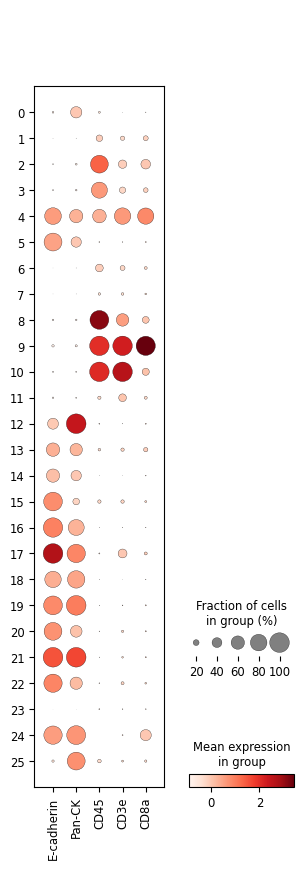

In [22]:
sc.pl.dotplot(adata, sub_markers, groupby="leiden_clusters")

E-cadherin Otsu Threshold: 6.023722861953278


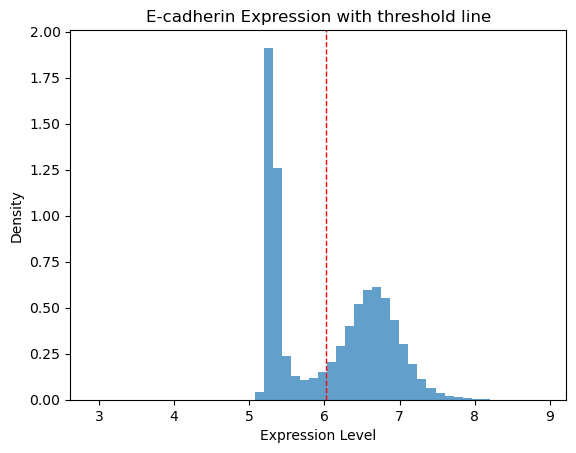

Pan-CK Otsu Threshold: 6.162268998482873


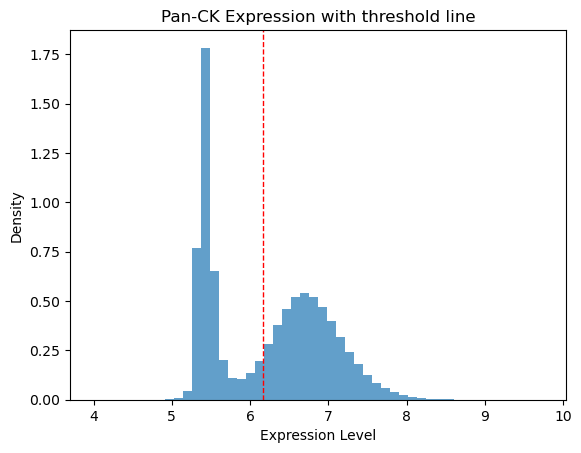

CD45 Otsu Threshold: 6.2158191781286565


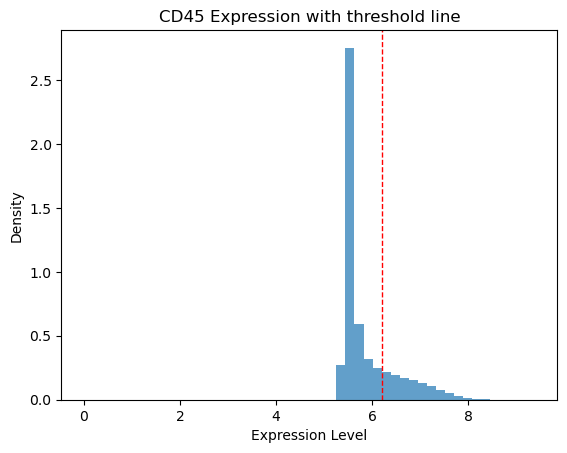

CD3e Otsu Threshold: 6.096258095393861


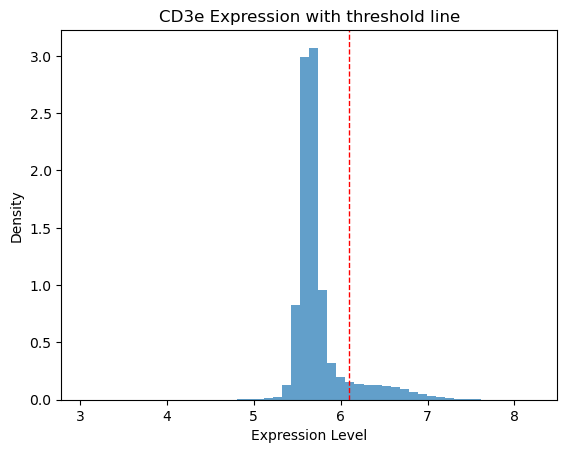

CD8a Otsu Threshold: 5.922373279233398


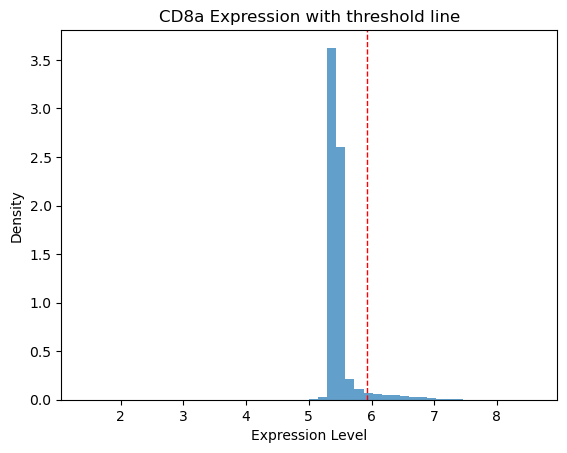

In [26]:
for marker in sub_markers:
    temp = data[marker].dropna().values  # ensure numeric, no NaNs
    thr = threshold_otsu(temp)

    print(f"{marker} Otsu Threshold: {thr}")

    plt.figure()
    plt.hist(temp, bins=50, density=True, alpha=0.7)  # density plot
    plt.axvline(thr, color='red', linestyle='dashed', linewidth=1)
    plt.title(f"{marker} Expression with threshold line")
    plt.xlabel("Expression Level")
    plt.ylabel("Density")
    plt.show()

In [ ]:
# get total amount of cells annotated per method
# columns: Cluster Annotation, Cell Type

summary = data.groupby(["Cluster Annotation", "Cell Type"]).size().reset_index(name='Count')
print(summary)

  Cluster Annotation     Cell Type   Count
0         CD8 T Cell    CD8 T Cell   14504
1         CD8 T Cell  Not Assigned   72193
2         CD8 T Cell    Tumor Cell    9884
3         Tumor Cell  Not Assigned   88799
4         Tumor Cell    Tumor Cell  662201


In [35]:
# sankey diagram

# first one being E-cadherin_strat -> Pan-CK_strat
# second one being CD8a_strat -> CD3e_strat -> CD45_strat

# render in browser because I get some errors with nbformat
pio.renderers.default = "browser"

counts1 = data.groupby(["E-cadherin_strat", "Pan-CK_strat"]).size().reset_index(name="count")
labels1 = [
    "E-cadherin:0", "E-cadherin:1",
    "Pan-CK:0", "Pan-CK:1"
]
label_index1 = {lab: i for i, lab in enumerate(labels1)}

sources1, targets1, values1 = [], [], []
for _, row in counts1.iterrows():
    s = label_index1[f"E-cadherin:{row['E-cadherin_strat']}"]
    t = label_index1[f"Pan-CK:{row['Pan-CK_strat']}"]
    sources1.append(s)
    targets1.append(t)
    values1.append(int(row["count"]))

fig1 = go.Figure(go.Sankey(
    node=dict(label=labels1, pad=15, thickness=20),
    link=dict(source=sources1, target=targets1, value=values1)
))
fig1.update_layout(title_text="E-cadherin → Pan-CK", font_size=12)
fig1.show()

In [37]:
# count combinations for adjacent pairs
counts2a = data.groupby(["CD45_strat", "CD3e_strat"]).size().reset_index(name="count")
counts2b = data.groupby(["CD3e_strat", "CD8a_strat"]).size().reset_index(name="count")

labels2 = [
    "CD45:0", "CD45:1",
    "CD3e:0", "CD3e:1",
    "CD8a:0", "CD8a:1"
]
label_index2 = {lab: i for i, lab in enumerate(labels2)}

sources2, targets2, values2 = [], [], []

# CD45 → CD3e
for _, row in counts2a.iterrows():
    s = label_index2[f"CD45:{row['CD45_strat']}"]
    t = label_index2[f"CD3e:{row['CD3e_strat']}"]
    sources2.append(s)
    targets2.append(t)
    values2.append(int(row["count"]))

# CD3e → CD8a
for _, row in counts2b.iterrows():
    s = label_index2[f"CD3e:{row['CD3e_strat']}"]
    t = label_index2[f"CD8a:{row['CD8a_strat']}"]
    sources2.append(s)
    targets2.append(t)
    values2.append(int(row["count"]))

fig2 = go.Figure(go.Sankey(
    node=dict(label=labels2, pad=15, thickness=20),
    link=dict(source=sources2, target=targets2, value=values2)
))
fig2.update_layout(title_text="CD45 → CD3e → CD8a", font_size=12)
fig2.show()


In [39]:
data.head()

,CellID,leiden_clusters,CD31_strat,CD45_strat,CD68_strat,CD4_strat,FOXP3_strat,CD8a_strat,CD45RO_strat,CD20_strat,...,Ki67_strat,Pan-CK_strat,SMA_strat,E-cadherin,Pan-CK,CD45,CD3e,CD8a,Cluster Annotation,Cell Type
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,5.220457,5.368944,5.383941,5.211964,5.250509,Tumor Cell,Not Assigned
1,2,1,1,0,0,0,0,0,0,0,...,0,0,0,5.361907,5.349588,6.096482,5.584760,5.605817,None,Not Assigned
2,3,11,0,0,0,0,0,0,0,0,...,0,0,0,5.204007,5.357344,5.288293,5.175740,5.263066,None,Not Assigned
3,4,23,0,0,0,0,0,0,0,0,...,0,0,1,5.254389,4.924550,5.385608,5.433433,5.365644,None,Not Assigned
4,5,23,0,0,0,0,0,0,0,0,...,0,0,1,5.272533,5.072614,5.423510,5.491416,5.383435,None,Not Assigned


In [58]:
# transfer annotations to adata
adata.obs["CD8a_clusters_ann"] = (data["Cluster Annotation"] == "CD8 T Cell").values
adata.obs["CD8a_dict_ann"]     = (data["Cell Type"] == "CD8 T Cell").values
adata.obs["tumor_clusters_ann"] = (data["Cluster Annotation"] == "Tumor Cell").values
adata.obs["tumor_dict_ann"]     = (data["Cell Type"] == "Tumor Cell").values



/var/folders/br/wg7_xdjd56j7rb8h39m_2f240000gn/T/ipykernel_83100/3964816728.py:2: FutureWarning:

Use `squidpy.pl.spatial_scatter` instead.



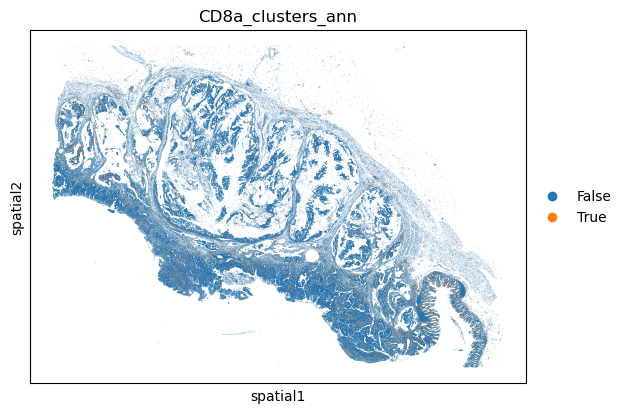

In [59]:
# check spatial locations
sc.pl.spatial(adata, color=["CD8a_clusters_ann"], spot_size=30)

/var/folders/br/wg7_xdjd56j7rb8h39m_2f240000gn/T/ipykernel_83100/4306458.py:1: FutureWarning:

Use `squidpy.pl.spatial_scatter` instead.



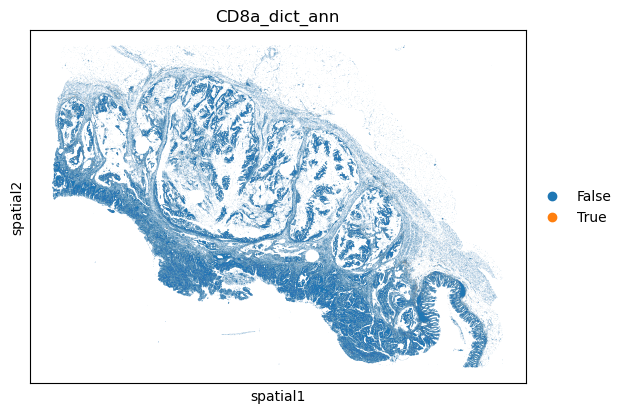

In [60]:
sc.pl.spatial(adata, color=["CD8a_dict_ann"], spot_size=30)

/var/folders/br/wg7_xdjd56j7rb8h39m_2f240000gn/T/ipykernel_83100/1222182188.py:1: FutureWarning:

Use `squidpy.pl.spatial_scatter` instead.



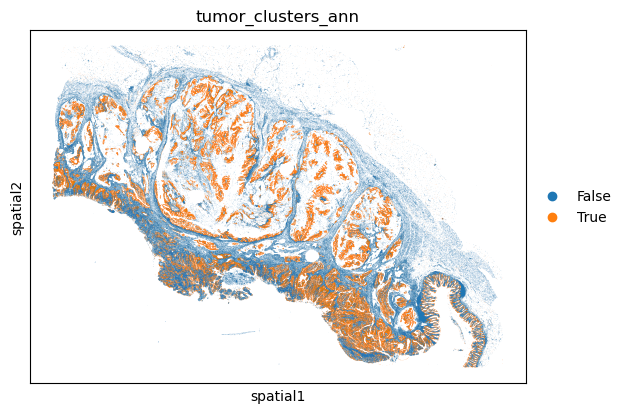

In [61]:
sc.pl.spatial(adata, color=["tumor_clusters_ann"], spot_size=30)

In [ ]:
sc.pl.spatial(adata, color=["tumor_dict_ann"], spot_size=30)

/var/folders/br/wg7_xdjd56j7rb8h39m_2f240000gn/T/ipykernel_83100/3808216596.py:1: FutureWarning:

Use `squidpy.pl.spatial_scatter` instead.

